[(4, 0), (4, 9), (5, 1), (8, 0), (8, 9), (0, 5), (6, 2), (7, 1), (4, 2), (3, 6), (5, 3), (8, 2), (9, 1), (0, 7), (2, 4), (1, 8), (6, 4), (7, 3), (3, 8), (8, 4), (9, 3), (7, 5), (5, 7), (9, 5), (0, 2), (1, 3), (5, 0), (5, 9), (9, 7), (1, 5), (6, 1), (7, 0), (7, 9), (3, 5), (9, 0), (1, 7), (2, 6), (7, 2), (3, 7), (4, 6), (9, 2), (8, 6), (1, 9), (2, 8), (7, 4), (6, 8), (3, 0), (3, 9), (5, 6), (4, 8), (1, 2), (0, 4), (4, 1), (8, 1), (1, 4), (0, 6), (2, 3), (6, 3), (3, 4), (8, 3), (1, 6), (0, 8), (2, 5), (4, 5), (8, 5), (9, 4), (0, 1), (2, 7), (6, 7), (4, 7), (5, 8), (9, 6), (0, 3), (2, 9), (6, 0), (6, 9), (7, 8)]
[(2, 4, 8), (1, 3, 8), (2, 5, 7), (2, 3, 6), (0, 5, 7), (3, 7, 8), (0, 1, 8), (4, 6, 7), (3, 8, 9), (2, 3, 4), (1, 4, 5), (3, 4, 9), (0, 7, 8), (4, 8, 9), (3, 5, 6), (1, 2, 7), (2, 5, 8), (1, 2, 8), (0, 1, 6), (1, 4, 8), (4, 7, 9), (0, 1, 4), (2, 5, 9), (1, 4, 6), (1, 6, 9), (0, 2, 3), (5, 7, 8), (0, 2, 7), (0, 4, 5), (0, 7, 9), (1, 7, 8), (1, 4, 9), (1, 2, 9), (0, 5, 6), (4, 5, 8

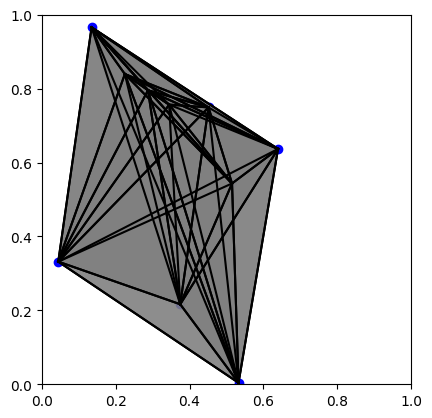

In [18]:
import matplotlib.pyplot as plt
import random
import itertools

class SimplicialComplex:
    def __init__(self, num_vertices):
        self.num_vertices = num_vertices
        self.vertices = {i: self.random_point() for i in range(num_vertices)}
        # We generate faces first, then make edges from them
        self.faces = self.generate_faces()
        self.edges = self.generate_edges()

    def generate_faces(self):
        potential_faces = list(itertools.combinations(range(self.num_vertices), 3))
        return random.sample(potential_faces, k=random.randint(1, len(potential_faces)))

    def generate_edges(self):
        res = []
        for (a, b, c) in self.faces:
            res.append((a, b))
            res.append((b, c))
            res.append((c, a))
        return list(set(res))

    def display(self):
        fig, ax = plt.subplots()
        ax.set_aspect('equal')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

        for v in self.vertices.values():
            ax.scatter(*v, color='blue')

        for edge in self.edges:
            v0, v1 = self.vertices[edge[0]], self.vertices[edge[1]]
            plt.plot([v0[0], v1[0]], [v0[1], v1[1]], color='black')

        for face in self.faces:
            polygon = [self.vertices[v] for v in face]
            polygon.append(polygon[0])  # close the polygon
            xs, ys = zip(*polygon)
            plt.fill(xs, ys, alpha=0.3, color='grey')

        plt.show()

    @staticmethod
    def random_point():
        return random.uniform(0, 1), random.uniform(0, 1)

sc = SimplicialComplex(10)
print(sc.edges)
print(sc.faces)
sc.display()
